# 1D Simulator
This code is used to simulate 1D equations in order to create some data for ai training. 

The first part will be the reprodcution of the heat diffusion in 1D such as :
$$
\begin{equation}
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
\end{equation}
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## 1D Grid creation helper

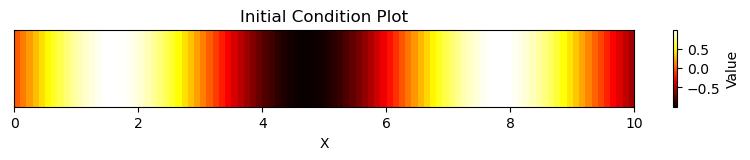

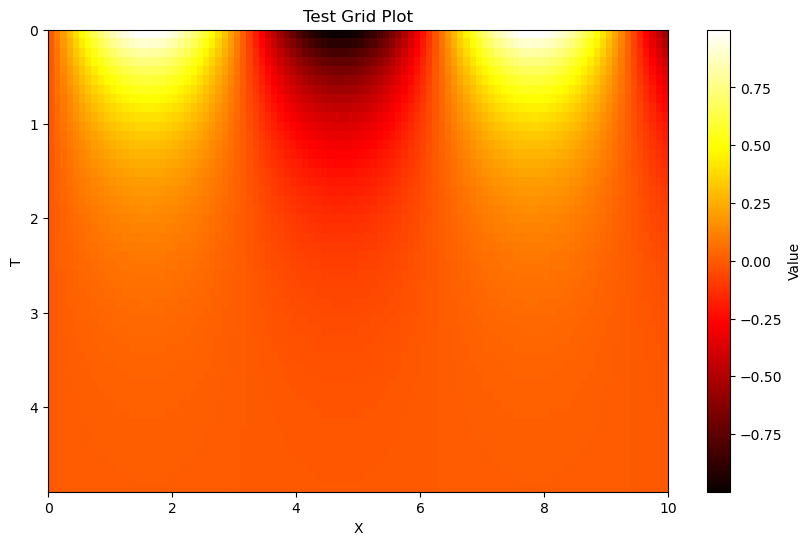

In [3]:
# Grid helper
class Grid1D:
    def __init__(self, nb_points_x, x_max, nb_points_t, dt):
        self.nb_points_x = nb_points_x
        self.x_max = x_max
        self.nb_points_t = nb_points_t
        self.dt = dt

        self.dx = x_max / (nb_points_x - 1)
        self.x = np.linspace(0, x_max, nb_points_x)
        self.t = np.linspace(0, dt * (nb_points_t - 1), nb_points_t)

        self.X, self.T = np.meshgrid(self.x, self.t)


    def plot(self, U, title="1D Simulation", xlabel="X", ylabel="T"):
        plt.figure(figsize=(10, 6))
        plt.imshow(
            U,
            extent=[self.X.min(), self.X.max(), self.T.max(), self.T.min()],
            cmap='hot',
            interpolation='nearest',   # empêche le lissage
            aspect='auto',             # conserve le bon rapport largeur/hauteur
            origin='upper'             # ou 'lower' selon ton orientation
        )
        plt.colorbar(label='Value')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    def plot_initial_condition(self, U, title="X_initial"):
        plt.figure(figsize=(10, 1))
        U0 = U[0, :]  # condition initiale à t=0
        plt.imshow(
            U0[np.newaxis, :],                      # rend la ligne 2D (1xN)
            extent=[self.X.min(), self.X.max(), 0, 1],
            cmap='hot',
            interpolation='nearest',
            aspect='auto',
            origin='lower'
        )

        plt.colorbar(label='Value')
        plt.title(title)
        plt.xlabel("X")
        plt.yticks([])  # on cache l’axe vertical (inutile pour une ligne)
        plt.show()

    def generate_npz(self, U, filename="grid1d_data.npz"):
        np.savez_compressed(filename, U=U, x=self.x, t=self.t, dx=self.dx, dt=self.dt)


# Test the Grid1D class
grid = Grid1D(nb_points_x=100, x_max=10, nb_points_t=50, dt=0.1)
grid.plot_initial_condition(np.sin(grid.X), title="Initial Condition Plot")
grid.plot(np.sin(grid.X) * np.exp(-1 * grid.T), title="Test Grid Plot")



## Thermal Diffusion 1D solver

In [4]:
# Thermal Diffusion Simulator in 1D
class ThermalDiffusion1D:
    def __init__(self, grid, alpha, initial_condition, boundary_condition):
        self.grid = grid
        self.alpha = alpha
        self.initial_condition = initial_condition
        self.boundary_condition = boundary_condition

    def deriv1order(self, U):
        # U : 1D array of length nx
        nx = U.shape[0]
        dUdx = np.zeros_like(U)
        if nx >= 3:
            dUdx[1:-1] = (U[2:] - U[:-2]) / (2 * self.grid.dx)
        if nx >= 2:
            dUdx[0] = (U[1] - U[0]) / self.grid.dx
            dUdx[-1] = (U[-1] - U[-2]) / self.grid.dx
        return dUdx

    def deriv2order(self, U):
        # U : 1D array of length nx
        nx = U.shape[0]
        d2Udx2 = np.zeros_like(U)
        if nx >= 3:
            d2Udx2[1:-1] = (U[2:] - 2 * U[1:-1] + U[:-2]) / (self.grid.dx ** 2)
        if nx >= 2:
            d2Udx2[0] = (U[1] - 2 * U[0] + U[0]) / (self.grid.dx ** 2)
            d2Udx2[-1] = (U[-1] - 2 * U[-1] + U[-2]) / (self.grid.dx ** 2)
        return d2Udx2

    def simulate(self):
        nt = len(self.grid.t)
        nx = len(self.grid.x)
        U = np.zeros((nt, nx))
        U[0, :] = self.initial_condition(self.grid.x)

        for n in range(nt - 1):
            d2Udx2 = self.deriv2order(U[n, :])
            U[n + 1, :] = U[n, :] + self.alpha * d2Udx2 * self.grid.dt

            # Apply boundary conditions (expects tuple (left, right))
            left, right = self.boundary_condition(self.grid.t[n + 1])
            U[n + 1, 0], U[n + 1, -1] = left, right

        return U

### Exemple of usage for the creation of a sim of the 1D thermal equation

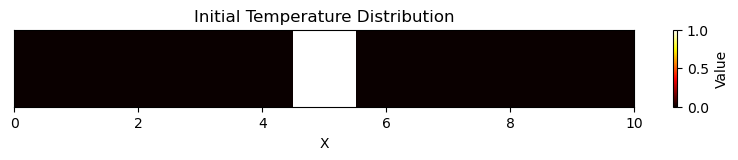

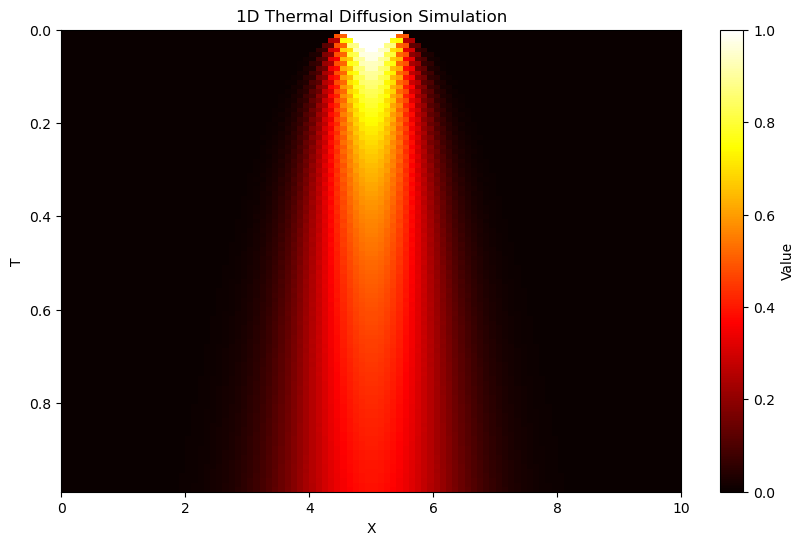

In [5]:
# Example usage
nbx = 100
nbt = 100
x_max = 10
dt = 0.01

initial_x = np.zeros_like(grid.x)
center_idx = len(grid.x) // 2
start_idx = center_idx - 5
end_idx = center_idx + 5
initial_x[start_idx:end_idx] = 1.0

alpha = 0.5

grid = Grid1D(nbx, x_max, nbt, dt)
simulator = ThermalDiffusion1D(
    grid,
    alpha,
    initial_condition=lambda x: initial_x,
    boundary_condition=lambda t: (0.0, 0.0)
)
U = simulator.simulate()
grid.plot_initial_condition(U, title="Initial Temperature Distribution")
grid.plot(U, title="1D Thermal Diffusion Simulation", xlabel="X", ylabel="T")


In [ ]:
# Generate dataset of simulations with random initial conditions
nsamples = 100

for i in range(nsamples):
    init = np.random.rand(nbx)  # random initial_x as requested
    sim = ThermalDiffusion1D(
        grid,
        alpha,
        initial_condition=lambda x, init=init: init,      # capture init
        boundary_condition=lambda t: (0.0, 0.0)
    )
    Usim = sim.simulate()
    filename = f"generated/thermal_diffusion_1d_sample_{i:03d}.npz"
    grid.generate_npz(Usim, filename=filename)